In [2]:
from pybullet_suite import *
from kinjax import *
from jax import jit, vmap
import jax.numpy as jnp
#import kdtree
import open3d as o3d
#from rot import ec

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
urdf = "panda.urdf"
ee_link_name = "panda_grasptarget"
world = BulletWorld(gui=False)
panda = world.load_robot(Panda, "panda")
dof = 7
link_dict, joint_dict = get_link_joint_dict(urdf)
fk = get_FK_fn(link_dict, joint_dict, dof, ee_link_name)
fk_batch = get_FK_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)
jac = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name)
jac_batch = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name, batch=True)

argv[0]=
Robot name: panda


In [3]:
grid_max = jnp.array([1, 1, 1.5, np.pi, np.pi, np.pi]) #xyzrpy
grid_min = jnp.array([-1, -1, -0.5, -np.pi, -np.pi, -np.pi])
num_grids = jnp.array([40, 40, 40, 12,12,12])
grid_size = (grid_max - grid_min) / num_grids

from jax import lax
def mat2rpy(R):
    def singular_case(R, sy): #cos(p) = 0
        r = jnp.arctan2(-R[1,2], R[1,1])
        p = jnp.arctan2(-R[2,0], sy)
        y = 0.
        return jnp.array([r, p, y])
    def normal_case(R, sy):
        r = jnp.arctan2(R[2,1] , R[2,2])
        p = jnp.arctan2(-R[2,0], sy)
        y = jnp.arctan2(R[1,0], R[0,0])
        return jnp.array([r, p, y])
    sy = jnp.sqrt(R[2,1]**2 + R[2,2]**2)
    return lax.cond(sy < 1e-6, singular_case, normal_case, R, sy)
    
def to_pose_vec(pose_mat):
    return jnp.hstack([pose_mat[:3, -1], mat2rpy(pose_mat[:3, :3])])
    
def get_grid_index(pose_mat):
    pose_vec = to_pose_vec(pose_mat)
    grid_index = (pose_vec - grid_min) // grid_size
    return grid_index.astype(int)

get_grid_index_batch = jit(vmap(get_grid_index))

def get_manipulability_batch(joints):
    poses = fk_batch(joints)
    jacs = jac_batch(joints)
    manips = jnp.sqrt(jnp.linalg.det(jnp.einsum("ijk,ilk->ijl", jacs, jacs)))
    indexes = get_grid_index_batch(poses)
    return indexes, manips
get_manipulability_batch = jit(get_manipulability_batch)

In [4]:
grids = {}

In [7]:
indexes

array([[13, 29, 17,  7,  4,  9],
       [18,  1, 21,  7,  7,  4],
       [10, 17, 14,  8,  7,  8],
       ...,
       [10, 14, 17, 10,  5,  3],
       [20, 13, 12,  0,  6,  9],
       [ 7, 11, 28,  5,  4,  8]], dtype=int32)

In [6]:
import time
for iter in range(1000):
    updated = 0
    
    #sample
    joints = jnp.array(np.random.uniform(panda.joint_lower_limit, panda.joint_upper_limit, (1000000, 7)))
    indexes, manips = get_manipulability_batch(joints)
    manips = jnp.nan_to_num(manips)
    indexes, manips = np.array(indexes), np.array(manips)

    #grid_num_before = len(grids)
    tic = time.time()
    for i in range(len(joints)):
        index = tuple(indexes[i].tolist())
        if index not in grids: #new grid
            grids[index] = {}
            grids[index]["num"] = 0
            grids[index]["sum"] = 0.
            updated += 1
        
        #if grids[index] < manips[i]:
        #manip = jnp.nan_to_num(manips[i].item())
        grids[index]["sum"] += manips[i]
        grids[index]["num"] += 1
        
    print(time.time()-tic)
    #grid_num_after = len(grids)
    print(f"iter:{iter}  updated:{updated}") #, num_grid:{grid_num_after}, filled_grids:{grid_num_after - grid_num_before}")

1.8072679042816162
iter:0  updated:157008
1.80245041847229
iter:1  updated:150246
1.7968928813934326
iter:2  updated:144306


KeyboardInterrupt: 

In [58]:
jnp.prod(num_grids)

Array(110592000, dtype=int32)

In [19]:
import pickle
with open("manip_grid_avg_12.pkl", "wb") as f:
    pickle.dump(grids, f)

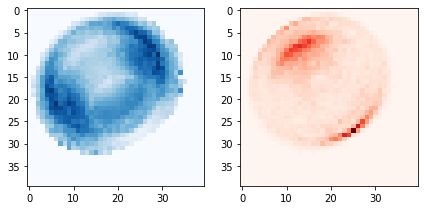

In [18]:
import matplotlib.pyplot as plt

x_range, y_range = range(40), range(40)
z = 20
roll, pitch, yaw = 0, 3, 0

manip_map = np.zeros((40,40))
reach_map = np.zeros((40,40))
for x in x_range:
    for y in y_range:
        key = (x, y, z, roll, pitch, yaw)
        if key not in grids: 
            #print(f"{x,y}")
            continue
        manip_map[x, y] = grids[key]["sum"]/ grids[key]["num"]
        reach_map[x, y] = grids[key]["num"]
        if grids[key]["num"] == 1: #. and grids[key]["num"] != 0:
            pass #print(f"{x,y}")

fig, axes = plt.subplots(1, 2, figsize=[7, 14])
bar = axes[0].imshow(manip_map, cmap="Blues")
axes[1].imshow(reach_map, cmap="Reds")
#plt.colorbar(bar)

In [61]:
key

(20, 20, 20, 0, 3, 0)

Text(0, 0.5, 'yaw')

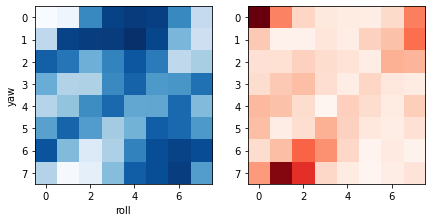

In [85]:
import matplotlib.pyplot as plt

x, y, z = 22, 23, 25
roll_range, pitch, yaw_range = range(8), 2, range(8)

manip_map = np.zeros((8,8))
reach_map = np.zeros((8,8))
for roll in roll_range:
    for yaw in yaw_range:
        key = (x, y, z, roll, pitch, yaw)
        if key not in grids: 
            #print(f"{x,y}")
            continue
        manip_map[roll, yaw] = grids[key]["sum"]/ grids[key]["num"]
        reach_map[roll, yaw] = grids[key]["num"]
        if grids[key]["num"] == 1: #. and grids[key]["num"] != 0:
            pass #print(f"{x,y}")

fig, axes = plt.subplots(1, 2, figsize=[7, 14])
bar = axes[0].imshow(manip_map, cmap="Blues")
axes[1].imshow(reach_map, cmap="Reds")
axes[0].set_xlabel("roll")
axes[0].set_ylabel("yaw")
#plt.colorbar(bar)

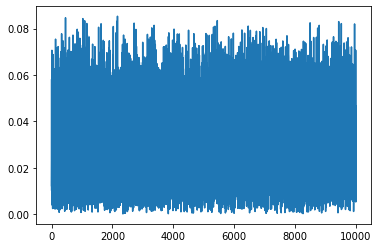

In [30]:
import matplotlib.pyplot as plt
plt.plot(manips)

In [31]:
get_grid_index(fk(joints[6]), grid_min, grid_size)

Array([27, 22, 26,  0,  3,  3], dtype=int32)

In [3]:
class FKSampler:
    def __init__(self, fk, fk_batch):
        self.data = {}
        self.tree = kdtree.create(dimensions=7)
        self.fk = fk
        self.fk_batch = fk_batch
        #self.fk_batch = ji

    def add(self, q):
        if tuple(q) in  self.data: return
        self.tree.add(q)
        T = self.fk(q)
        self.data[tuple(q)] = (T,)
    
    def pose_distance(self, q1, q2, weight=0.3):
        def angle(R1, R2):
            R = R1.T@R2
            return jnp.arccos((jnp.trace(R) - 1) / 2)
        def norm(x1, x2):
            return jnp.linalg.norm(x1-x2)
        T1, T2 = self.fk_batch(jnp.vstack([q1, q2]))
        return norm(T1[:3, -1], T2[:3, -1]) + weight * angle(T1[:3, :3], T2[:3, :3])
    
    def nearest(self, q):
        return self.tree.search_nn(q)[0].data

    def dense_resampling(self, q1, q2, min_dist=0.2, metric_fn=None):
        if metric_fn is None:
            metric_fn = self.pose_distance
        self.add(q1)
        self.add(q2)
        if metric_fn(q1, q2) > min_dist:
            qmid = (q1 + q2) / 2
            self.dense_resampling(q1, qmid)
            self.dense_resampling(qmid, q2)

In [ ]:
world = BulletWorld(gui=True)
panda = world.load_robot(Panda, "panda")
sm = BulletSceneMaker(world)

In [71]:
table = {}

In [ ]:
def get_index(poses):
    xyzrot = 

In [68]:
joints = jnp.array(np.random.uniform(panda.joint_lower_limit, panda.joint_upper_limit, size=(1000,7)))
Ts = fk_batch(joints)
jacs = jac_batch(joints)
manip = jnp.sqrt(jnp.linalg.det(jacs @ jacs.swapaxes(2, 1)))
manip = np.array(manip)
manip[np.isnan(manip)] = 0.

In [69]:
colors = np.zeros((len(manip), 3))
colors[:,0] = manip / np.max(manip)

In [70]:
pc = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
pc.normals = o3d.utility.Vector3dVector(zs)
pc.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pc])

In [ ]:
sampler = FKSampler(fk, fk_batch)
q1 = panda.get_random_config()
sampler.add(q1)

while len(sampler.data) < 10000:
    print(len(sampler.data))
    q_rand = panda.get_random_config()
    q_near = sampler.nearest(q_rand)
    sampler.dense_resampling(q_near, q_rand)

In [44]:
q_rand = panda.get_random_config()
q_near = sampler.nearest(q_rand)

In [8]:
for i, q in enumerate(sampler.data.keys()):
    pose = Pose.from_matrix(np.array(sampler.data[tuple(q)][0]))
    sm.view_point(pose.trans, f"{i}")

In [ ]:
for frame in list(world.frames.keys()):
    sm.remove_frame(frame)
for point in list(world.bodies.keys()):
    sm.remove_frame(frame)

In [177]:
for frame in list(world.frames.keys()):
    sm.remove_frame(frame)

In [174]:
q_rand = panda.get_random_config()
q_near = sampler.nearest(q_rand)
for i, q in enumerate(np.linspace(q_rand, q_near, 20)):
    pose = Pose.from_matrix(np.array(fk(q)))
    sm.view_frame(pose, f"{i}")

In [187]:
n_samples = 100
points = np.random.random((10000, 7))
points_left = np.arange(len(points))
sample_inds = np.zeros(n_samples, dtype="int")

dists = np.ones_like(points_left) * float('inf')
selected = 0
sample_inds[0] = points_left[selected]
points_left = np.delete(points_left, selected)

In [4]:
def _fps(points, n_samples):
    """
    points: [N, 3] array containing the whole point cloud
    n_samples: samples you want in the sampled point cloud typically << N 
    """
    # init
    points_left = jnp.ones(len(points)).astype(bool) #boolean index
    sample_inds = jnp.zeros(n_samples).astype(int)
    dists = jnp.ones_like(points_left) * float('inf') # [P]

    # Select a point from points by its index, save it
    selected = 0
    sample_inds = sample_inds.at[0].set(selected)
    points_left = points_left.at[selected].set(False)

    for i in range(n_samples):
        last_added = sample_inds[i-1]
        dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points, axis=-1)
        update_cond = jnp.bitwise_and(dist_to_last_added_point < dists, points_left)
        dists = jnp.where(update_cond, dist_to_last_added_point, dists)
        selected = np.argmax(jnp.where(points_left, dists, jnp.zeros_like(dists)))
        sample_inds = sample_inds.at[i].set(selected)
        points_left = points_left.at[selected].set(False)
    return points[sample_inds]

_fps = jit(_fps, static_argnums=1)
def fps(points, n_samples, batch_size=100):
    n_batch = n_samples // batch_size
    batch_sizes = [batch_size]*n_batch
    batch_sizes += [n_samples - np.sum(batch_sizes)]
    steps = [0, *np.cumsum(batch_sizes)]
    for i in range(len(steps[:-1])):
        start, end = steps[i], steps[i+1] 
        _fps(points[start:end], end-start)

In [9]:
n_samples = 1024
batch_size = 100
n_batch = n_samples // batch_size
batch_sizes = [batch_size]*n_batch
batch_sizes += [n_samples - np.sum(batch_sizes)]
np.cumsum(batch_sizes)

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1024])

In [10]:
points = jnp.array(np.random.random((100000,2)))
n_samples = 100
sampled = jit(_fps, static_argnums=1)(points, n_samples)

In [6]:
%timeit jit(fps, static_argnums=1)(points, n_samples)

125 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
sampled = fps(points, 1000)

In [9]:
import matplotlib.pyplot as plt

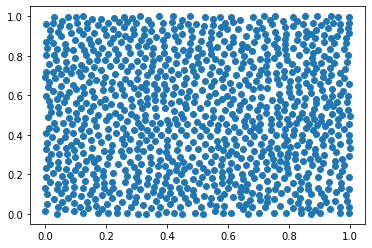

In [10]:
plt.scatter(*sampled.T)

In [ ]:
for i in range(1, n_samples):
    last_added = sample_inds[i-1]
    dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points[points_left], axis=-1)
    updates = jnp.minimum(dist_to_last_added_point, dists[points_left])
    dists = dists.at[points_left].set(updates)
    selected = jnp.argmax(dists[points_left])
    sample_inds = sample_inds.at[i].set(points_left[selected])
    points_left = jnp.delete(points_left, selected)

In [64]:
points = jnp.array(np.random.random((10000,2)))
n_samples = 100

# init
points_left = jnp.ones(len(points)).astype(bool) #boolean index
sample_inds = jnp.zeros(n_samples).astype(int)
dists = jnp.ones_like(points_left) * float('inf') # [P]

# Select a point from points by its index, save it
selected = 0
sample_inds = sample_inds.at[0].set(selected)
points_left = points_left.at[selected].set(False)

for i in range(n_samples):
    print(i)
    last_added = sample_inds[i-1]
    dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points, axis=-1)
    update_cond = jnp.bitwise_and(dist_to_last_added_point < dists, points_left)
    dists = jnp.where(update_cond, dist_to_last_added_point, dists)
    selected = np.argmax(jnp.where(points_left, dists, jnp.zeros_like(dists)))
    sample_inds = sample_inds.at[i].set(selected)
    points_left = points_left.at[selected].set(False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
# points_left = points_left.at[selected].set(False)

# Iteratively select points for a maximum of n_samples
#for i in range(1, n_samples):
i = 1
last_added = sample_inds[i-1]
dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points, axis=-1)

updates = jnp.minimum(dist_to_last_added_point, dists)
jnp.where(dist_to_last_added_point < dists[points_left], dist_to_last_added_point)
dists = dists.at[points_left].set(updates)
selected = np.argmax(dists[points_left])
sample_inds = sample_inds.at[i].set(points_left[selected])
points_left = points_left.at[selected].set(False)
return points[sample_inds]

In [50]:
updates

Array([0.28072256, 0.        , 0.8130836 , ..., 0.724894  , 0.6238547 ,
       0.15327685], dtype=float32)

In [49]:
updates

Array([0.28072256, 0.        , 0.8130836 , ..., 0.724894  , 0.6238547 ,
       0.15327685], dtype=float32)

In [34]:
dists.at[points_left]

_IndexUpdateRef(Array([inf, inf, inf, ..., inf, inf, inf], dtype=float32, weak_type=True), Array([False,  True,  True, ...,  True,  True,  True], dtype=bool))

In [33]:
points_left

Array([False,  True,  True, ...,  True,  True,  True], dtype=bool)

In [21]:
last_added = sample_inds[i-1]
dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points[points_left], axis=-1)
updates = jnp.minimum(dist_to_last_added_point, dists[points_left])
dists = dists.at[points_left].set(updates)
selected = jnp.argmax(dists[points_left])
sample_inds = sample_inds.at[i].set(points_left[selected])
#points_left = jnp.delete(points_left, selected)
i += 1
sample_inds

Array([   0,  927, 4982, 6479,  306, 4060, 3035, 8576, 2044, 4176, 6317,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [216]:
for i in range(1, n_samples):
    last_added = sample_inds[i-1]
    dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points[points_left], axis=-1)
    updates = jnp.minimum(dist_to_last_added_point, dists[points_left])
    dists = dists.at[points_left].set(updates)
    selected = jnp.argmax(dists[points_left])
    sample_inds = sample_inds.at[i].set(points_left[selected])
    points_left = jnp.delete(points_left, selected)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Array([       inf, 0.1865625 , 0.45844367, ..., 0.9644993 , 0.49169737,
       0.7903657 ], dtype=float32, weak_type=True)

In [210]:
points_left

Array([   1,    2,    3, ..., 9997, 9998, 9999], dtype=int32)

In [ ]:
i = 1
    # Find the distance to the last added point in selected
    # and all the others
    last_added = sample_inds[i-1]
    
    dist_to_last_added_point = jnp.linalg.norm(points[last_added] - points[points_left], axis=-1)

    # If closer, updated distances
    dists[points_left] = jnp.minimum(dist_to_last_added_point, 
                                        dists[points_left]) # [P - i]

    # We want to pick the one that has the largest nearest neighbour
    # distance to the sampled points
    selected = np.argmax(dists[points_left])
    sample_inds[i] = points_left[selected]

    # Update points_left
    points_left = np.delete(points_left, selected)

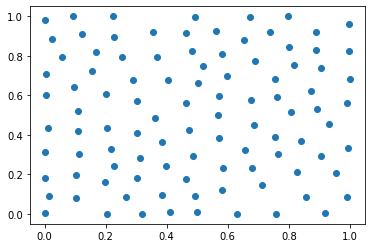

In [198]:
import matplotlib.pyplot as plt
plt.scatter(*points.T)

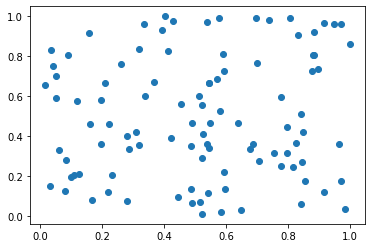

In [200]:
plt.scatter(*np.random.random((100,2)).T)

In [9]:
q1 = panda.get_random_config()
q2 = panda.get_random_config()
qs = jnp.vstack([q1, q2])
T1, T2 = fk_batch(qs)

In [11]:
T2

Array([[ 0.3268735 ,  0.94070673,  0.09069017,  0.2847451 ],
       [-0.06428745,  0.11787192, -0.9909457 , -0.8382619 ],
       [-0.9428791 ,  0.31808355,  0.09900483,  0.40123323],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)